In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
from torchvision.models.segmentation import fcn_resnet50
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    return image

def load_mask(img_path):
    mask_path = re.sub(r"(.*)(part\d+)(.*)\.jpg", r"\1res_\2\3.tif", img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))
    mask = (mask == 255).astype(np.uint8)  # Convert 255 to 1 (background) and 0 to 0 (residue)
    return mask

class CropResidueDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.image_paths[idx])

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask, dtype=torch.long)  # Binary mask (1 for residue, 0 for background)
        return image, mask

In [4]:
data_dir = "/content/drive/MyDrive/residue_background/Limbaugh1-1m20220328/IMG_0629"
# Use glob to search for all images in all subdirectories recursively
image_paths = sorted(glob(os.path.join(data_dir, "IMG_*_part*.jpg"), recursive=True))
# image_paths = sorted(glob(os.path.join(data_dir, "**", "IMG_*_part*.jpg"), recursive=True))

In [5]:
train_images, val_images = train_test_split(image_paths, test_size=0.2, random_state=42)

train_dataset = CropResidueDataset(train_images)
val_dataset = CropResidueDataset(val_images)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)  # Binary segmentation
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 85.4MB/s]


In [7]:
def calculate_iou(pred, target):
    # Flatten the tensor
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = intersection.float() / union.float()
    return iou

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    epoch_iou = []  # To store IoU values for plotting

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_preds = []
        all_targets = []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']

            # Get predictions (argmax) and compute loss
            preds = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Store predictions and masks for IoU and confusion matrix calculation
            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

        # Calculate IoU
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        iou = calculate_iou(torch.tensor(all_preds), torch.tensor(all_targets))
        epoch_iou.append(iou.item())

        # Plot IoU vs Epochs
        plt.plot(range(1, epoch+2), epoch_iou)
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.title('IoU vs Epochs')
        plt.grid(True)
        plt.pause(0.1)

        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}, IoU: {iou.item()}")

    plt.show()

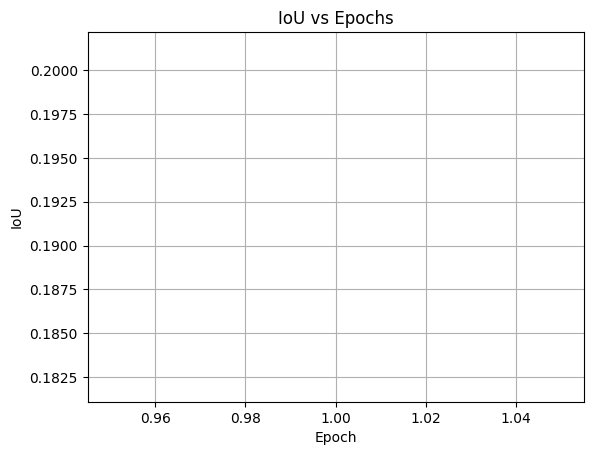

Epoch 1, Loss: 0.7466633915901184, IoU: 0.19163286685943604


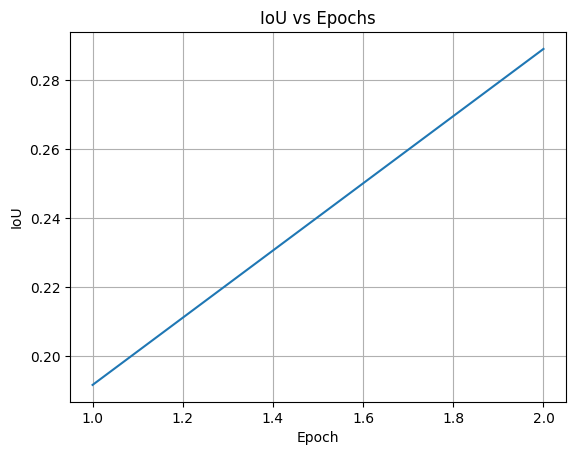

Epoch 2, Loss: 0.5995045602321625, IoU: 0.2890058159828186


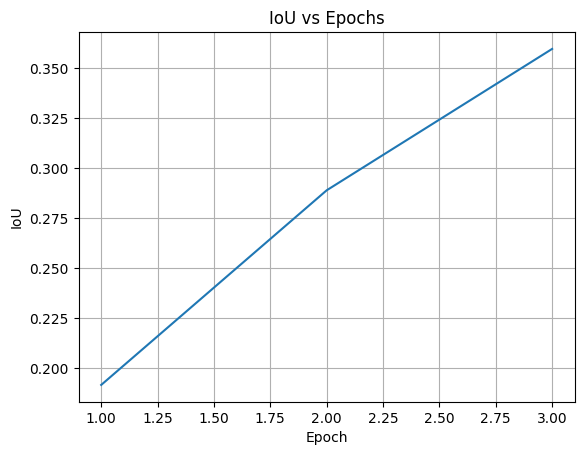

Epoch 3, Loss: 0.5057270377874374, IoU: 0.359760046005249


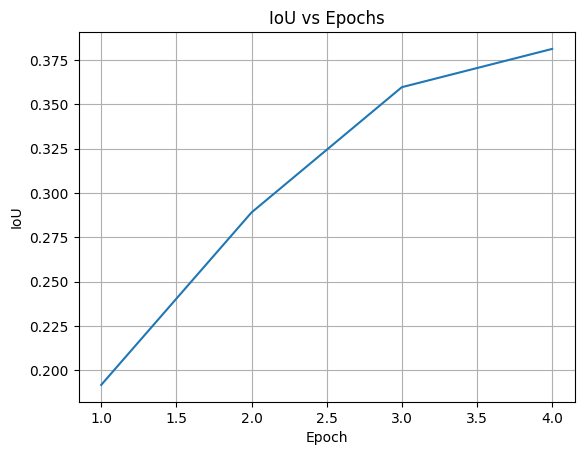

Epoch 4, Loss: 0.43714453279972076, IoU: 0.3813721537590027


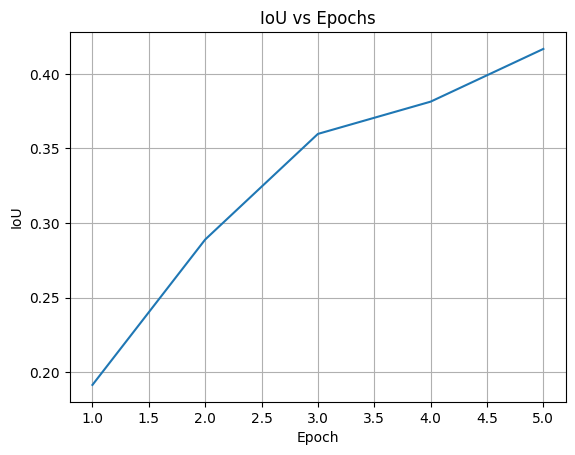

Epoch 5, Loss: 0.40740425884723663, IoU: 0.4166872203350067


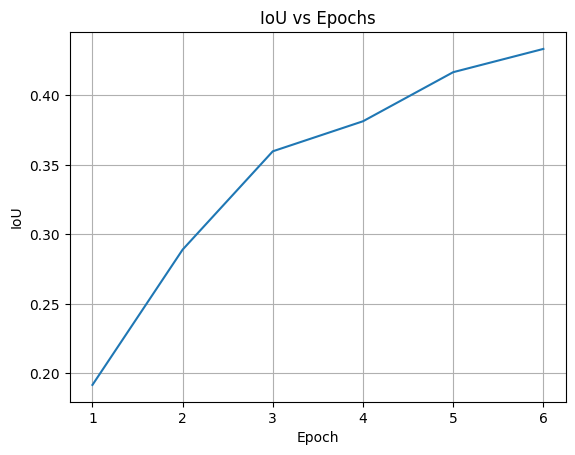

Epoch 6, Loss: 0.4073036164045334, IoU: 0.4334282875061035


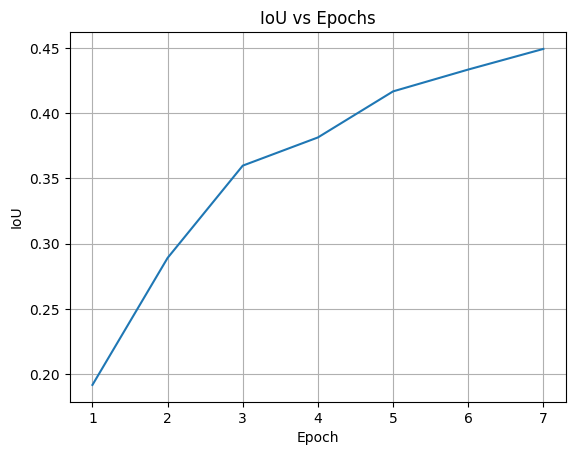

Epoch 7, Loss: 0.38328221440315247, IoU: 0.4492458999156952


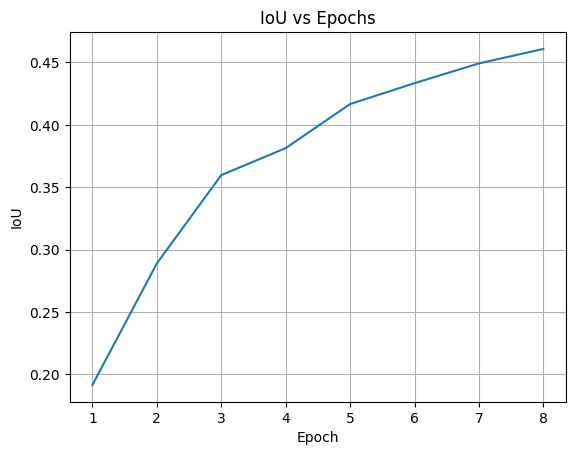

Epoch 8, Loss: 0.37505149841308594, IoU: 0.460868239402771


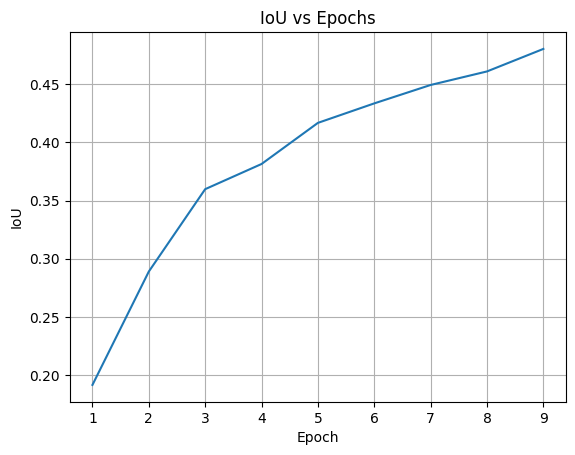

Epoch 9, Loss: 0.3638466149568558, IoU: 0.48020386695861816


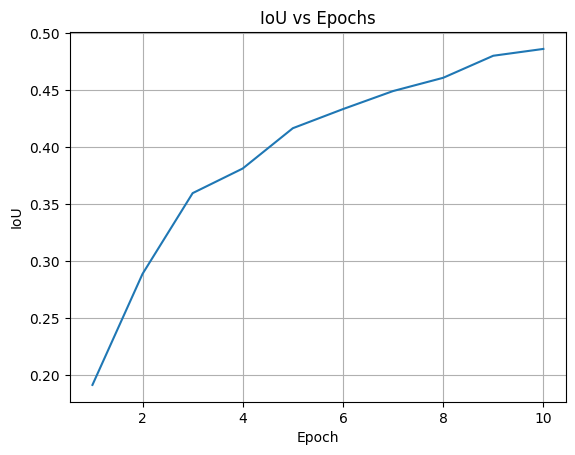

Epoch 10, Loss: 0.35308894515037537, IoU: 0.48618751764297485


In [9]:
train_model(model, train_loader, val_loader, criterion, optimizer)